# 3 Task Based Language Model

1. Initialisation
2. Training
3. Fine-tuning
4. Evaluation

Dataset of interest:
    1. Long non-coding RNA (lncRNA) vs. messenger RNA (mRNA)
        - 

## 3.1 Initialisation
### 3.1.1 Imports 

In [1]:
# Set it to a particular device
import torch
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import pandas as pd
from pathlib import Path
from functools import partial

from utils import tok_fixed, tok_variable, get_model_LM
import sys; sys.path.append("../tools"); from config import *
from utils import *

### 3.1.2 mRNA/lncRNA Data initialisation

In [4]:
data_df = pd.read_csv(HUMAN/'lncRNA.csv', usecols=['Sequence','Name'])

# data for LM fine-tuning
df_ulm              = (data_df[data_df['Name'].str.contains('TRAIN.fa')].pipe(partition_data))
df_tr_,df_va_       = df_ulm[df_ulm.set == 'train'], df_ulm[df_ulm.set == 'valid']

# dfs for classification
df_clas             = (data_df[data_df['Name'].str.contains('train16K')].pipe(partition_data))
df_clas['Target']   = df_clas['Name'].map(lambda x : x.split('.')[0][:-1])
df_tr,df_va         = df_clas[df_clas.set == 'train'], df_clas[df_clas.set == 'valid']
df_te               = data_df[data_df['Name'].str.contains('TEST500')]

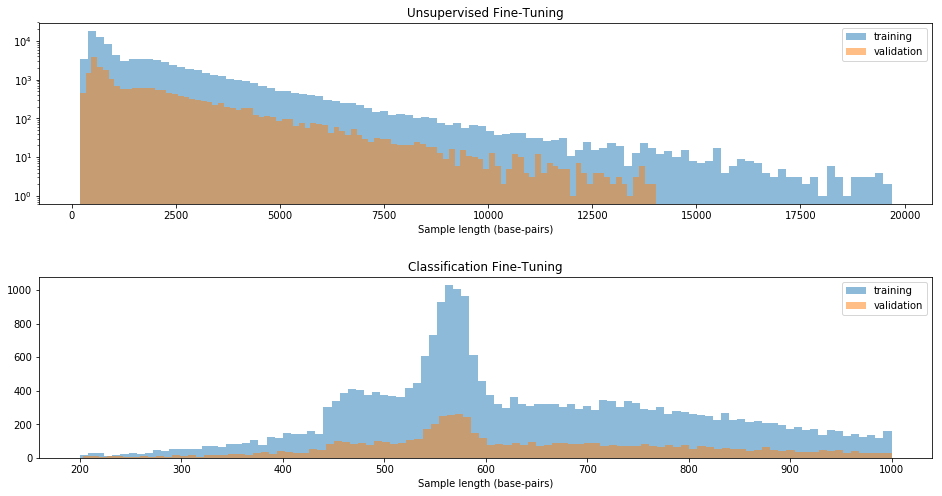

In [18]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, figsize = (16,8));
# suptitle = 'Domain Training Data: Distribution by Sample Length'
# _=fig.suptitle(suptitle)
plt.subplots_adjust(hspace=0.4)

_=df_tr_['Sequence'].str.len().sort_values().head(-50).hist(bins=100, log=True, ax=axes[0], alpha=0.5, label='training')
_=df_va_['Sequence'].str.len().sort_values().head(-50).hist(bins=100, log=True, ax=axes[0], alpha=0.5, label='validation')
_=axes[0].set_title('Unsupervised Fine-Tuning'); _=axes[0].set_xlabel('Sample length (base-pairs)'); _=axes[0].legend(); 
axes[0].grid(False)
# axes[0].set_xscale('log')

_=df_tr['Sequence'].str.len().sort_values().hist(bins=100, ax=axes[1], alpha=0.5, label='training')
_=df_va['Sequence'].str.len().sort_values().hist(bins=100, ax=axes[1], alpha=0.5, label='validation')
_=axes[1].set_title('Classification Fine-Tuning'); _=axes[1].set_xlabel('Sample length (base-pairs)'); _=axes[1].legend()
axes[1].grid(False)

fig.savefig(FIGURES/'ulmfit'/suptitle.lower().replace(' ','_'), dpi=fig.dpi, bbox_inches='tight', pad_inches=0.5)

## 3.2 LM Fine-Tuning

In [5]:
%%time
def make_experiments(df_tr, df_va):
    """Construct experiment based on tokenisation parameters explored.
    """
    experiments = []

    # fixed length
    for i,ngram_stride in enumerate(NGRAM_STRIDE):
        experiment = {}
        experiment['title'] = 'fixed_{}_{}_rows_{}'.format(*ngram_stride,NROWS_TRAIN)
        experiment['xdata'], experiment['vocab'] = tok_fixed(df_tr, df_va, *ngram_stride, bs=BS[i])

        experiments.append(experiment)

    # variable length   
    for i,max_vocab in enumerate(MAX_VOCAB):
        experiment = {}
        experiment['title'] = 'variable_{}_rows_{}'.format(max_vocab,NROWS_TRAIN)    
        experiment['xdata'], experiment['vocab'] = tok_variable(df_tr, df_va, max_vocab, bs=BS[i])

        experiments.append(experiment)
    return experiments

experiments = make_experiments(df_tr_, df_va_)

CPU times: user 52.6 s, sys: 44.5 s, total: 1min 37s
Wall time: 2min 45s


In [6]:
TUNE_CONFIG     = dict(emb_sz=400, 
                       n_hid=1150, 
                       n_layers=3,
                       pad_token=0, 
                       qrnn=False, 
                       output_p=0.25, 
                       hidden_p=0.1, 
                       input_p=0.2,
                       embed_p=0.02, 
                       weight_p=0.15, 
                       tie_weights=True, 
                       out_bias=True)
TUNE_DROP_MULT  = 0.25

def tune_model(experiment, epochs=1):
    config      = TUNE_CONFIG.copy()
    drop_mult   = TUNE_DROP_MULT
    
    data  = experiment['xdata']
    learn = get_model_LM(data, drop_mult, config)
    learn = learn.to_fp16(dynamic=True); # convert model weights to 16-bit float
    
    model = 'models/' + experiment['title'] + '.pth'
    if os.path.exists(HUMAN/model):
        print('model found: loading model: {}'.format(experiment['title']))
        learn.load(experiment['title'])
        learn.data = data

    # add callbacks
    from fastai.callbacks.csv_logger import CSVLogger
    learn.callback_fns.append(partial(CSVLogger, 
                                      filename='history_tune_' + experiment['title'], 
                                      append=True))
    
    learn.fit(epochs=epochs,wd=1e-4)
    learn.save('tune_'+experiment['title'])
    learn.save_encoder('tune_'+experiment['title']+'_enc')
    
    # free up cuda
    del learn; del data; torch.cuda.empty_cache()

for experiment in experiments[-1:]:
    print(experiment['title'])
    tune_model(experiment, epochs=4)

variable_16384_rows_20000
model found: loading model: variable_16384_rows_20000


epoch,train_loss,valid_loss,accuracy,time
0,8.436018,8.375731,0.056398,11:39
1,8.070114,8.026074,0.082648,11:40
2,7.789114,7.773710,0.105557,11:40
3,7.618844,7.615263,0.122452,11:39


## 3.3 Classification

In [ ]:
%%time
def make_experiments(df_tr, df_va):
    """Construct experiment based on tokenisation parameters explored.
    """
    experiments = []

    # fixed length
    for i,ngram_stride in enumerate(NGRAM_STRIDE):
        experiment = {}
        experiment['title'] = 'fixed_{}_{}_rows_{}'.format(*ngram_stride,NROWS_TRAIN)
        experiment['xdata'], experiment['vocab'] = tok_fixed(df_tr, df_va, *ngram_stride, 
                                                             bs=400, clas=True)

        experiments.append(experiment)

    # variable length   
    for i,max_vocab in enumerate(MAX_VOCAB):
        experiment = {}
        experiment['title'] = 'variable_{}_rows_{}'.format(max_vocab,NROWS_TRAIN)
        experiment['xdata'], experiment['vocab'] = tok_variable(df_tr, df_va, max_vocab, 
                                                                bs=400, clas=True)

        experiments.append(experiment)
        
    return experiments

experiments = make_experiments(df_tr, df_va)

In [ ]:
CLAS_CONFIG     = dict(emb_sz=400, 
                       n_hid=1150, 
                       n_layers=3, 
                       pad_token=0, 
                       qrnn=False, 
                       output_p=0.4,
                       hidden_p=0.2, 
                       input_p=0.6,
                       embed_p=0.1, 
                       weight_p=0.5)
CLAS_DROP_MULT  = 0.5

def tune_classifier(experiment, epochs=1):
    config      = CLAS_CONFIG.copy()
    drop_mult   = CLAS_DROP_MULT

    data  = experiment['xdata']
    learn = get_model_clas(data, CLAS_DROP_MULT, CLAS_CONFIG, max_len=4000*70)
    learn.load_encoder(experiment['title']+'_enc')
    learn = learn.to_fp16(dynamic=True);
    
    # add callbacks
    from fastai.callbacks.csv_logger import CSVLogger
    learn.callback_fns.append(partial(CSVLogger, 
                                      filename='history_clas' + experiment['title'], 
                                      append=True))
    
    learn.freeze()
    learn.fit_one_cycle(epochs, 5e-2, moms=(0.8, 0.7))
    learn.save('clas_'+experiment['title'])
    learn.save_encoder('clas_'+experiment['title']+'_enc')
    
tune_classifier(experiments[1], epochs=4)

In [ ]:
CLAS_CONFIG     = dict(emb_sz=400, 
                       n_hid=1150, 
                       n_layers=3, 
                       pad_token=0, 
                       qrnn=False, 
                       output_p=0.4,
                       hidden_p=0.2, 
                       input_p=0.6,
                       embed_p=0.1, 
                       weight_p=0.5)
CLAS_DROP_MULT  = 0.5
tune_classifier(experiments[1], epochs=4)

## 3.4 Evaluation
We now evaluate every model trained for classification performance on the `TEST500` dataset.
All models have been trained for 10 epochs unsupervised, then fine tuned for an additional 8 epochs on long read ncRNA and mRNA data. We plot confusion matrices for each model, as well as a comparative accuracy plot.

In [ ]:
get_scores(learn)

## 3.5 Explainability
We would like to visualise the model's attention at the intersection between coding and non-coding regions.
- We would like to identify a subset of the model's embedding that captures the majority of this variance
- We could call this the `coding neuron`